In [1]:
import os
import urllib.request
import tarfile
from shutil import copyfile
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import transforms

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.datasets import ImageFolder

from torch.utils import model_zoo

from poutyne.framework import Model, ModelCheckpoint, BestModelRestore, CSVLogger, Experiment
from poutyne import torch_to_numpy, set_seeds

In [2]:
def download_and_extract_dataset(path):
    tgz_filename = "images.tgz"
    urllib.request.urlretrieve("http://www.vision.caltech.edu/visipedia-data/CUB-200/images.tgz", tgz_filename)
    os.makedirs(path, exist_ok=True)
    archive = tarfile.open(tgz_filename)
    archive.extractall(path)

In [3]:
def copy(source_path, filenames, dest_path):
    for filename in filenames:
        source = os.path.join(source_path, filename)
        dest = os.path.join(dest_path, filename)
        copyfile(source, dest)

def split_train_valid_test(dataset_path, train_path, valid_path, test_path, train_split=0.6, valid_split=0.2): # test_split=0.2
    np.random.seed(42)
    for classname in sorted(os.listdir(dataset_path)):
        if classname.startswith('.'):
            continue
        train_class_path = os.path.join(train_path, classname)
        valid_class_path = os.path.join(valid_path, classname)
        test_class_path = os.path.join(test_path, classname)

        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(valid_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        dataset_class_path = os.path.join(dataset_path, classname)
        filenames = sorted(filename for filename in os.listdir(dataset_class_path) if not filename.startswith('.'))
        np.random.shuffle(filenames)

        num_examples = len(filenames)
        train_last_idx = math.ceil(num_examples*train_split)
        valid_last_idx = train_last_idx + math.floor(num_examples*valid_split)
        train_filenames = filenames[0:train_last_idx]
        valid_filenames = filenames[train_last_idx:valid_last_idx]
        test_filenames = filenames[valid_last_idx:]
        copy(dataset_class_path, train_filenames, train_class_path)
        copy(dataset_class_path, valid_filenames, valid_class_path)
        copy(dataset_class_path, test_filenames, test_class_path)

In [4]:
# We do the split train/valid/test.

base_path = './CUB200'
dataset_path = os.path.join(base_path, 'images')
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')
test_path = os.path.join(base_path, 'test')

In [5]:
download_and_extract_dataset(base_path)
split_train_valid_test(dataset_path, train_path, valid_path, test_path)

In [6]:
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

In [7]:
# Training hyperparameters

batch_size = 32
learning_rate = 0.1
n_epoch = 30
num_classes = 200

In [8]:
# Set Pythons's, NumPy's and PyTorch's seeds so that our training are (almost) reproducible.
set_seeds(42)

In [9]:
# Creation of the PyTorch's datasets for our problem.

norm_coefs = {}
norm_coefs['cub200'] = [(0.47421962,  0.4914721 ,  0.42382449), (0.22846779,  0.22387765,  0.26495799)]
norm_coefs['imagenet'] = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(*norm_coefs['cub200'])
])

train_set = ImageFolder(train_path, transform=transform)
valid_set = ImageFolder(valid_path, transform=transform)
test_set = ImageFolder(test_path, transform=transform)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [10]:
# Loading a pretrained ResNet-18 networks and replacing 
# the head with the number of neurons equal to our number 
# of classes.

resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

In [11]:
# We freeze the network except for its head.

def freeze_weights(resnet18):
    for name, param in resnet18.named_parameters():
        if not name.startswith('fc.'):
            param.requires_grad = False

freeze_weights(resnet18)

In [12]:
# One nice feature of Poutyne is callbacks.

callbacks = [
    # Save the latest weights to be able to resume the optimization at the end for more epochs.
    ModelCheckpoint('last_epoch.ckpt', temporary_filename='last_epoch.ckpt.tmp'),
    
    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint('best_epoch_{epoch}.ckpt', monitor='val_acc', mode='max', save_best_only=True, restore_best=True, verbose=True, temporary_filename='best_epoch.ckpt.tmp'),
    
    # Save the losses and accuracies for each epoch in a TSV.
    CSVLogger('log.tsv', separator='\t'),
]

In [13]:
# Finally, we start the training and output its final test 
# loss, accuracy, and micro F1-score.
# Note that the F1-score is quite similar to the accuracy 
# since the dataset is very balanced.

# Optimizer and loss function
optimizer = optim.SGD(resnet18.fc.parameters(), lr=learning_rate, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()

# Poutyne Model
model = Model(resnet18, optimizer, loss_function, batch_metrics=['accuracy'], epoch_metrics=['f1'])

# Send model on GPU
model.to(device)

# Train
model.fit_generator(train_loader, valid_loader, epochs=n_epoch, callbacks=callbacks)

# Test
test_loss, test_acc = model.evaluate_generator(test_loader)
print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

Epoch 1/30 30.23s Step 116/116: loss: 4.738788, acc: 6.731549, fscore_micro: 0.067315, val_loss: 3.886809, val_acc: 11.327434, val_fscore_micro: 0.113274
Epoch 1: val_acc improved from -inf to 11.32743, saving file to best_epoch_1.ckpt
Epoch 2/30 30.94s Step 116/116: loss: 3.006773, acc: 33.144093, fscore_micro: 0.331441, val_loss: 3.271729, val_acc: 21.592920, val_fscore_micro: 0.215929
Epoch 2: val_acc improved from 11.32743 to 21.59292, saving file to best_epoch_2.ckpt
Epoch 3/30 33.16s Step 116/116: loss: 2.153980, acc: 52.771019, fscore_micro: 0.527710, val_loss: 2.667525, val_acc: 35.752212, val_fscore_micro: 0.357522
Epoch 3: val_acc improved from 21.59292 to 35.75221, saving file to best_epoch_3.ckpt
Epoch 4/30 33.33s Step 116/116: loss: 1.666963, acc: 64.909435, fscore_micro: 0.649094, val_loss: 2.600248, val_acc: 36.106195, val_fscore_micro: 0.361062
Epoch 4: val_acc improved from 35.75221 to 36.10619, saving file to best_epoch_4.ckpt
Epoch 5/30 33.37s Step 116/116: loss: 1.3

In [14]:
logs = pd.read_csv('log.tsv', sep='\t')
print(logs)

best_epoch_idx = logs['val_acc'].idxmax()
best_epoch = int(logs.loc[best_epoch_idx]['epoch'])
print("Best epoch: %d" % best_epoch)

    epoch       time   lr      loss        acc  fscore_micro  val_loss  \
0       1  30.227874  0.1  4.738788   6.731549      0.067315  3.886809   
1       2  30.940623  0.1  3.006773  33.144093      0.331441  3.271729   
2       3  33.158612  0.1  2.153980  52.771019      0.527710  2.667525   
3       4  33.331771  0.1  1.666963  64.909435      0.649094  2.600248   
4       5  33.366570  0.1  1.336615  73.019735      0.730197  2.355025   
5       6  33.735695  0.1  1.119106  79.264666      0.792647  2.245564   
6       7  33.466024  0.1  0.942244  83.941606      0.839416  2.164859   
7       8  33.016263  0.1  0.834597  86.563936      0.865639  2.138340   
8       9  32.776520  0.1  0.707844  89.943228      0.899432  2.096751   
9      10  33.433662  0.1  0.657364  90.456880      0.904569  2.091874   
10     11  33.290968  0.1  0.579423  92.944039      0.929440  2.079854   
11     12  33.440002  0.1  0.518997  94.484996      0.944850  2.053490   
12     13  32.967461  0.1  0.477968  9

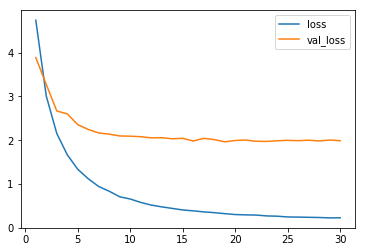

In [15]:
metrics = ['loss', 'val_loss']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

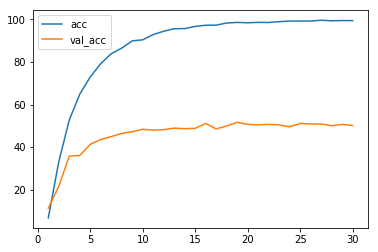

In [16]:
metrics = ['acc', 'val_acc']
plt.plot(logs['epoch'], logs[metrics])
plt.legend(metrics)
plt.show()

In [17]:
# Restore best model from checkpoint and test it.

resnet18 = models.resnet18(pretrained=False, num_classes=num_classes)

model = Model(resnet18, 'sgd', 'cross_entropy', batch_metrics=['accuracy'], epoch_metrics=['f1'])

model.to(device)

model.load_weights('best_epoch_{epoch}.ckpt'.format(epoch=best_epoch))

test_loss, test_acc = model.evaluate_generator(test_loader)
print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

Test:
	Loss: 2.065306835396345
	Accuracy: [49.83388704  0.49833888]


In [18]:
# Using the Experiment class
# This class saves checkpoints and logs as above in a directory
# and allows to stop and resume optimization at will. 
# See documentation for details.

def experiment_train(epochs=5):
    # Reload the pretrained network and freeze it except for its head.
    resnet18 = models.resnet18(pretrained=True)
    resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
    freeze_weights(resnet18)

    optimizer = optim.SGD(resnet18.fc.parameters(), lr=learning_rate, weight_decay=0.001)

    # Poutyne Experiment
    exp = Experiment('./cub200_resnet18_experiment', resnet18, device=device, optimizer=optimizer, task='classif')

    # Train
    exp.train(train_loader, valid_loader, epochs=epochs)

    # Test
    exp.test(test_loader)

experiment_train()

Epoch 1/5 29.48s Step 116/116: loss: 4.741102, acc: 6.596377, fscore_micro: 0.065964, val_loss: 3.973325, val_acc: 9.646018, val_fscore_micro: 0.096460
Epoch 1: val_acc improved from -inf to 9.64602, saving file to ./cub200_resnet18_experiment/checkpoint_epoch_1.ckpt
Epoch 2/5 29.44s Step 116/116: loss: 3.021139, acc: 31.603136, fscore_micro: 0.316031, val_loss: 3.140144, val_acc: 27.256637, val_fscore_micro: 0.272566
Epoch 2: val_acc improved from 9.64602 to 27.25664, saving file to ./cub200_resnet18_experiment/checkpoint_epoch_2.ckpt
Epoch 3/5 29.38s Step 116/116: loss: 2.161543, acc: 52.203298, fscore_micro: 0.522033, val_loss: 2.717716, val_acc: 34.247788, val_fscore_micro: 0.342478
Epoch 3: val_acc improved from 27.25664 to 34.24779, saving file to ./cub200_resnet18_experiment/checkpoint_epoch_3.ckpt
Epoch 4/5 29.40s Step 116/116: loss: 1.681555, acc: 63.909165, fscore_micro: 0.639092, val_loss: 2.411879, val_acc: 41.327434, val_fscore_micro: 0.413274
Epoch 4: val_acc improved fro

In [19]:
# Retrain for 5 more epochs
experiment_train(epochs=10)

Loading weights from ./cub200_resnet18_experiment/checkpoint.ckpt and starting at epoch 6.
Loading optimizer state from ./cub200_resnet18_experiment/checkpoint.optim and starting at epoch 6.
Epoch 6/10 30.04s Step 116/116: loss: 1.086491, acc: 80.183833, fscore_micro: 0.801838, val_loss: 2.226385, val_acc: 42.831858, val_fscore_micro: 0.428319
Epoch 6: val_acc improved from 41.32743 to 42.83186, saving file to ./cub200_resnet18_experiment/checkpoint_epoch_6.ckpt
Epoch 7/10 30.63s Step 116/116: loss: 0.919637, acc: 84.590430, fscore_micro: 0.845904, val_loss: 2.177427, val_acc: 46.460177, val_fscore_micro: 0.464602
Epoch 7: val_acc improved from 42.83186 to 46.46018, saving file to ./cub200_resnet18_experiment/checkpoint_epoch_7.ckpt
Epoch 8/10 31.05s Step 116/116: loss: 0.795253, acc: 87.834550, fscore_micro: 0.878345, val_loss: 2.148661, val_acc: 46.991150, val_fscore_micro: 0.469912
Epoch 8: val_acc improved from 46.46018 to 46.99115, saving file to ./cub200_resnet18_experiment/check